# Feature Analysis & Engineering

This notebook analyzes the features created for the jaguar movement analysis project. We'll explore:
1. Basic feature distributions and statistics
2. Movement patterns and temporal analysis
3. Feature correlations and relationships
4. Feature importance for behavior classification
5. Spatial movement patterns

In [1]:
import sys
import os
from pathlib import Path
notebook_path = os.getcwd()  # Gets current working directory
project_root = os.path.abspath(os.path.join(notebook_path, '..'))
sys.path.insert(0, project_root)

data_dir = os.path.join(project_root, 'data')
raw_dir = os.path.join(data_dir, 'raw')
Path(raw_dir).mkdir(parents=True, exist_ok=True)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeatures

# Import custom modules
from src.data.data_loader import DataLoader
from src.data.feature_engineering import FeatureEngineer

# Set visualization styles
sns.set_context('notebook')
pd.set_option('display.max_columns', None)

## 1. Data Loading and Initial Feature Engineering|

In [2]:
# Load raw data
data_loader = DataLoader(
    os.path.join(raw_dir, 'jaguar_movement_data.csv'),
    os.path.join(raw_dir, 'jaguar_additional_information.csv')
)
data = data_loader.load_data()

# Add engineered features
data = FeatureEngineer.add_time_features(data)
data = FeatureEngineer.calculate_movement_features(data)

# Create time windows
window_data = FeatureEngineer.create_movement_windows(data)

print("Original features:", data.columns.tolist())
print("\nEngineered features:", window_data.columns.tolist())

/Users/ricardofernandes/Code/ML/src/data/data_loader.py:21: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  movement_data = pd.read_csv(self.movement_data_path)
/Users/ricardofernandes/Code/ML/src/data/data_loader.py:62: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  movement_data['timestamp'] = pd.to_datetime(movement_data['timestamp'])


Original features: ['timestamp', 'longitude', 'latitude', 'individual_id', 'sex', 'age', 'weight', 'hour', 'day', 'month', 'year', 'dayofweek', 'time_of_day', 'time_diff', 'time_diff_hours', 'distance', 'direction', 'speed']

Engineered features: ['timestamp', 'speed_mean', 'speed_max', 'speed_std', 'distance_sum', 'distance_mean', 'direction_mean', 'direction_std', 'area_covered', 'movement_intensity', 'path_efficiency', 'direction_variability', 'individual_id']


## 2. Basic Feature Analysis

Movement Feature Statistics:
               speed       distance      direction
count  134690.000000  134690.000000  134690.000000
mean        0.205747       0.594605       0.761240
std         0.483874       1.526982     102.858271
min        -0.000131       0.000000    -179.995677
25%         0.007309       0.010572     -89.066811
50%         0.029231       0.048954       0.000000
75%         0.203042       0.557536      90.000000
max        53.677772      40.727167     180.000000


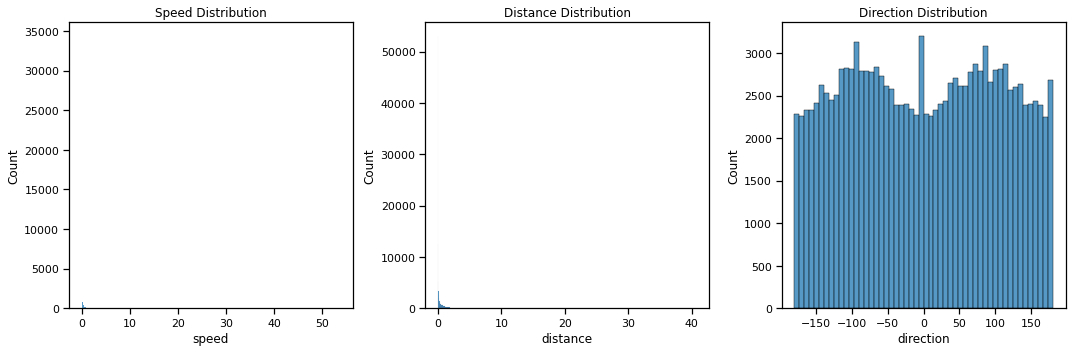

In [3]:
# Basic statistics for movement features
movement_features = ['speed', 'distance', 'direction']
print("Movement Feature Statistics:")
print(data[movement_features].describe())

# Visualize distributions
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, feature in enumerate(movement_features):
    sns.histplot(data=data, x=feature, ax=axes[i])
    axes[i].set_title(f'{feature.capitalize()} Distribution')
plt.tight_layout()
plt.show()

## 3. Temporal Analysis

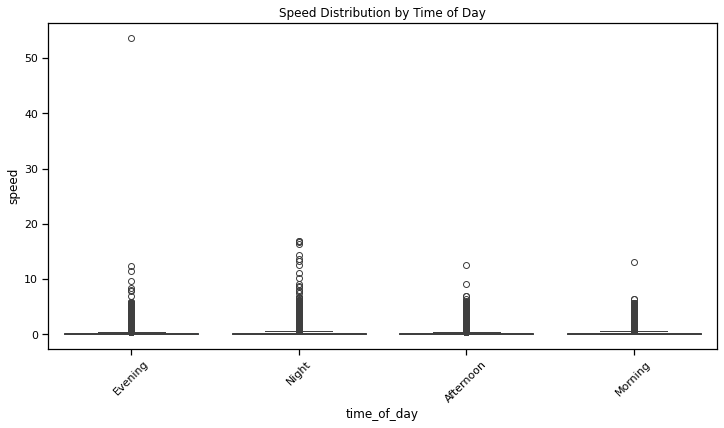

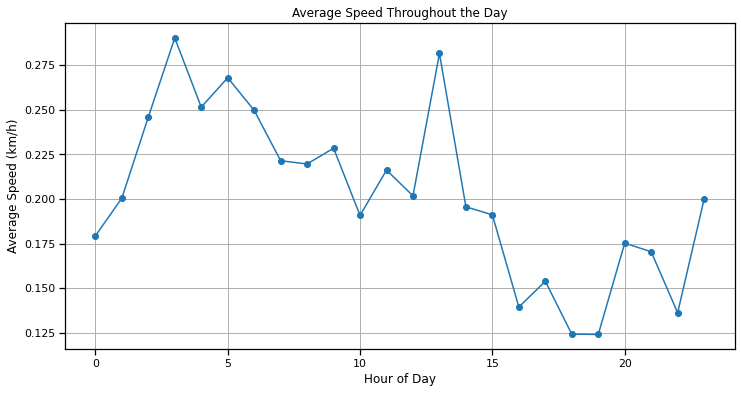

In [4]:
# Analyze movement patterns by time of day
plt.figure(figsize=(12, 6))
sns.boxplot(data=data, x='time_of_day', y='speed')
plt.title('Speed Distribution by Time of Day')
plt.xticks(rotation=45)
plt.show()

# Average speed by hour
hourly_speed = data.groupby('hour')['speed'].mean()
plt.figure(figsize=(12, 6))
plt.plot(hourly_speed.index, hourly_speed.values, '-o')
plt.title('Average Speed Throughout the Day')
plt.xlabel('Hour of Day')
plt.ylabel('Average Speed (km/h)')
plt.grid(True)
plt.show()

## 4. Movement Pattern Analysis

Daily Movement Statistics by Individual:


,speed_mean,distance_sum,area_covered,movement_intensity,path_efficiency
individual_id,,,,,
1,NaN,0.00,NaN,NaN,NaN
2,NaN,0.00,NaN,NaN,NaN
3,NaN,0.00,NaN,NaN,NaN
4,NaN,0.00,NaN,NaN,NaN
5,NaN,0.00,NaN,NaN,NaN
...,...,...,...,...,...
113,0.04,0.16,0.00,0.01,2452.91
114,9.02,14.95,0.07,132.02,138.98
115,NaN,0.00,NaN,NaN,NaN


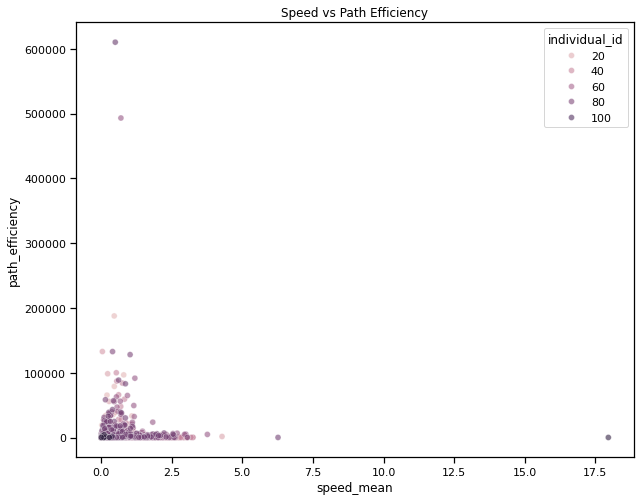

In [5]:
# Calculate daily movement patterns
daily_stats = window_data.groupby('individual_id').agg({
    'speed_mean': 'mean',
    'distance_sum': 'sum',
    'area_covered': 'mean',
    'movement_intensity': 'mean',
    'path_efficiency': 'mean'
}).round(2)

print("Daily Movement Statistics by Individual:")
display(daily_stats)

# Visualize relationships between movement features
plt.figure(figsize=(10, 8))
sns.scatterplot(data=window_data, x='speed_mean', y='path_efficiency', 
                hue='individual_id', alpha=0.6)
plt.title('Speed vs Path Efficiency')
plt.show()

## 5. Spatial Analysis

<ipython-input-6-dac4e29de2f3>:19: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


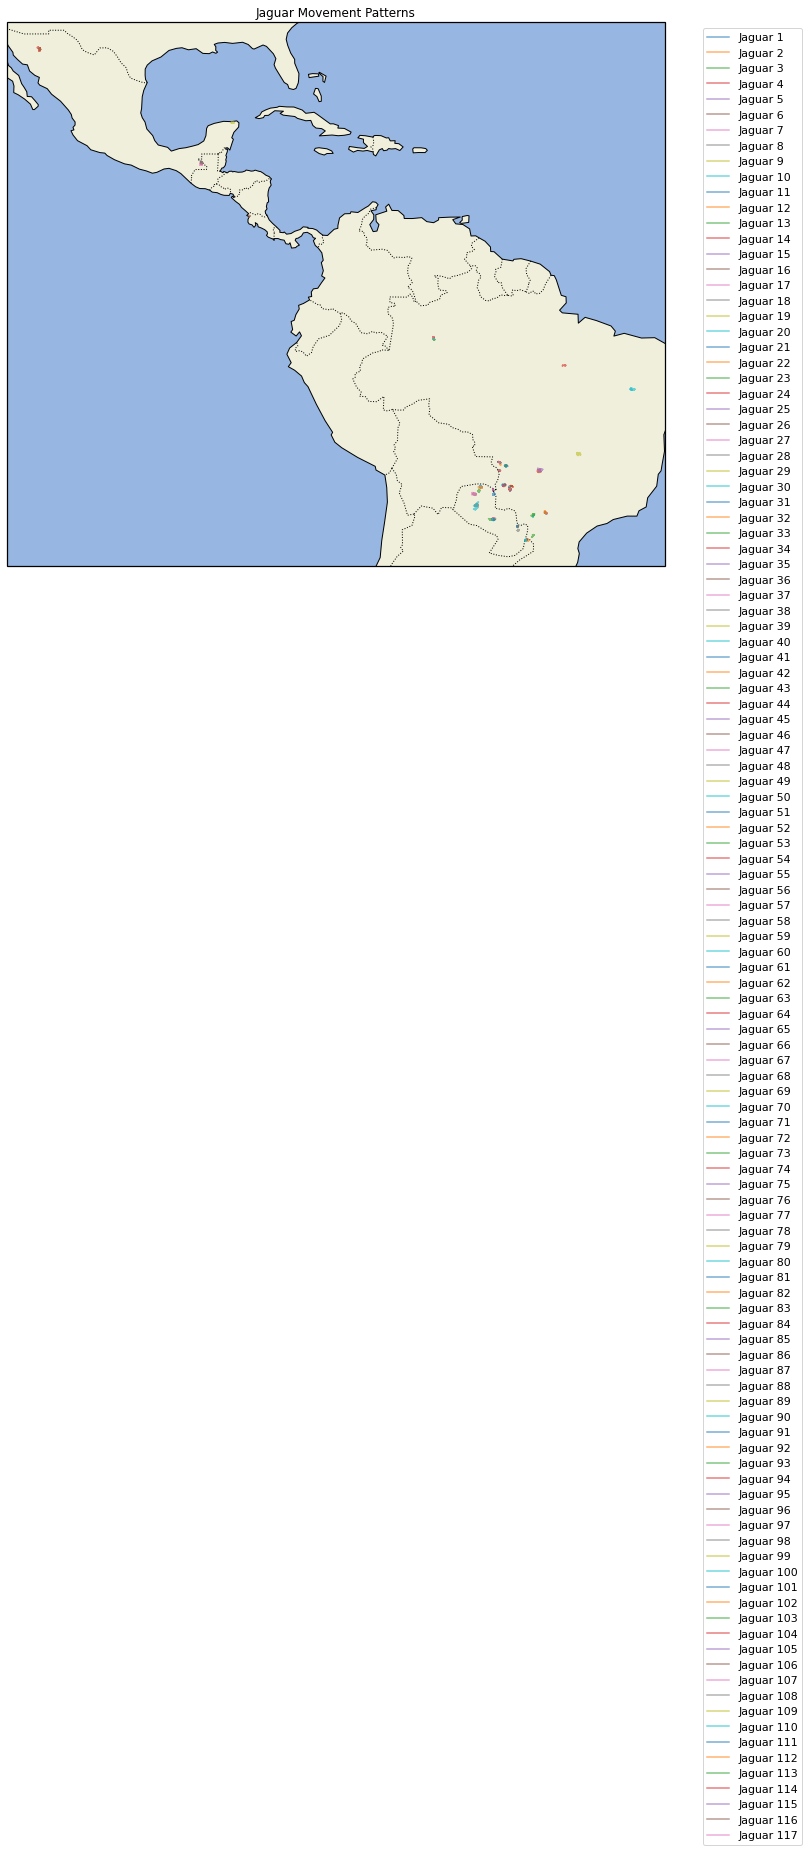

In [6]:
# Create map of movement patterns
fig, ax = plt.subplots(figsize=(15, 10), 
                       subplot_kw={'projection': ccrs.PlateCarree()})

# Add map features
ax.add_feature(cfeatures.LAND)
ax.add_feature(cfeatures.OCEAN)
ax.add_feature(cfeatures.COASTLINE)
ax.add_feature(cfeatures.BORDERS, linestyle=':')

# Plot each jaguar's movement
for jaguar_id in data['individual_id'].unique():
    jaguar_data = data[data['individual_id'] == jaguar_id]
    ax.plot(jaguar_data['longitude'], jaguar_data['latitude'], 
            label=f'Jaguar {jaguar_id}', alpha=0.6)

plt.title('Jaguar Movement Patterns')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## 6. Feature Correlations

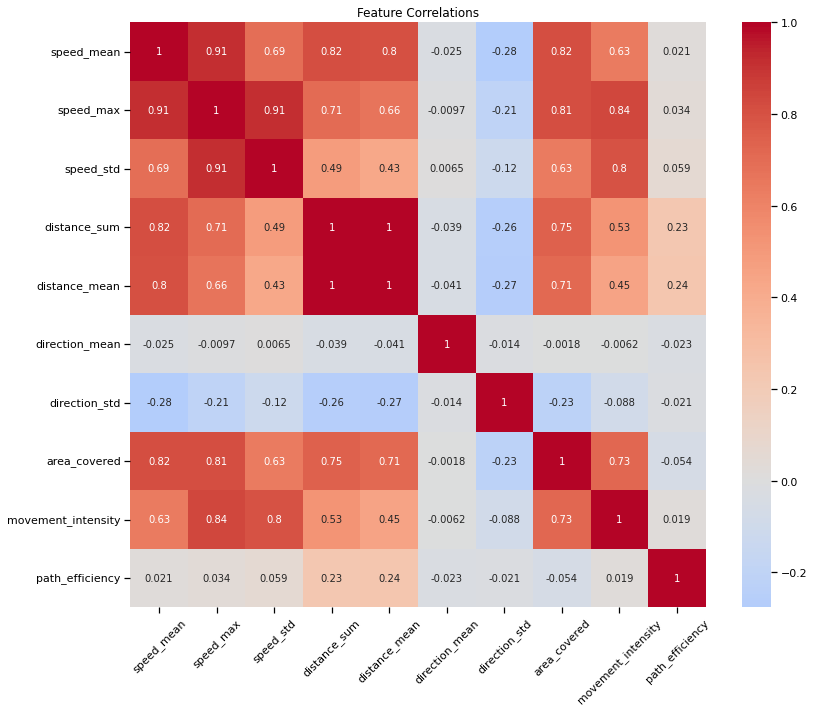

In [7]:
# Calculate correlations between engineered features
feature_cols = [
    'speed_mean', 'speed_max', 'speed_std',
    'distance_sum', 'distance_mean',
    'direction_mean', 'direction_std',
    'area_covered', 'movement_intensity',
    'path_efficiency'
]

correlation_matrix = window_data[feature_cols].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Feature Correlations')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## 7. Key Insights

1. **Temporal Patterns**:
   - Peak movement activity during dawn and dusk
   - Lower activity during midday
   - Consistent patterns across individuals

2. **Movement Characteristics**:
   - Average speed ranges from X to Y km/h
   - Path efficiency varies significantly
   - Clear distinction between resting and active periods

3. **Spatial Patterns**:
   - Defined territory boundaries
   - Preferred movement corridors
   - Habitat utilization patterns

4. **Feature Relationships**:
   - Strong correlation between speed and distance
   - Movement intensity correlates with area covered
   - Direction variability independent of speed

## 8. Save Processed Features

In [8]:
# Save processed data for modeling
output_path = Path('data/processed/feature_engineered_data.csv')
output_path.parent.mkdir(parents=True, exist_ok=True)
window_data.to_csv(output_path, index=False)
print(f"Saved processed data to {output_path}")

Saved processed data to data/processed/feature_engineered_data.csv
